In [7]:
import numpy as np
from scipy.integrate import odeint
import torch
import torchdiffeq
import matplotlib.pyplot as plt


In [8]:
inversionFree = False
constrained = False

c = torch.load('data/c.pt')
d = torch.load('data/d.pt')


def f(x, y):
    return torch.sin(c.T @ x + d.T @ y) + torch.log(torch.linalg.norm(x+y)**2 + 1)

def g(x, y):
    return 0.5 * torch.linalg.norm(x-y)**2


# if constrained:
#     A = torch.load('data/A.pt')
#     H = torch.load('data/H.pt')

#     def Lagrangian(x, z):
#         y = z[0:100]; nu = z[100:]
#         return g(x, y) + nu.T @ (A@x + H@y)

In [3]:
def calc_derivatives(x, y, nu=None):
    f_val = f(x,y)
    g_val = g(x,y)

    # 1st derivatives
    dfdy = torch.autograd.grad(f_val, y, create_graph=True)[0]
    dfdx = torch.autograd.grad(f_val, x, create_graph=True)[0]

    dgdy = torch.autograd.grad(g_val, y, create_graph=True)[0]
    dgdx = torch.autograd.grad(g_val, x, create_graph=True)[0]

    # Initialize tensors for 2nd derivatives
    dgdyy = torch.zeros((100, 100))
    dgdyx = torch.zeros((100, 100))
    # Compute 2nd derivatives element-wise
    for i in range(dgdy.shape[0]):
        dgdyy[i, :] = torch.autograd.grad(dgdy[i], y, retain_graph=True, create_graph=True)[0][:, 0]
        dgdyx[i, :] = torch.autograd.grad(dgdy[i], x, retain_graph=True, create_graph=True)[0][:, 0]
    
    if nu is None:
        return dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx
    else:
        # Compute Lagrangian derivatives
        z = torch.cat((y, nu), 0)
        L_val = Lagrangian(x, z)
        dLdx = torch.autograd.grad(L_val, x, create_graph=True)[0]
        dLdz = torch.autograd.grad(L_val, z, create_graph=True)[0]

        # Initialize tensors for 2nd derivatives
        dLdzx = torch.zeros((200, 100))
        dLdzz = torch.zeros((200, 200))
        # Compute 2nd derivatives element-wise
        for i in range(dLdz.shape[0]):
            dLdzz[i, :] = torch.autograd.grad(dLdz[i], z, retain_graph=True, create_graph=True)[0][:, 0]
            dLdzx[i, :] = torch.autograd.grad(dLdz[i], x, retain_graph=True, create_graph=True)[0][:, 0]
        return dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx, dLdx, dLdz, dLdzx, dLdzz

In [4]:
# Define the system of ODEs
def system_unconstrained(t, variables):
    alpha = 0.1
    epsilon = 0.1
    x, y = variables[:100], variables[100:]
    
    dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
    with torch.no_grad():    
        if inversionFree:
            try: dxdt;
            except NameError: dxdt = torch.zeros_like(x) # Not defined yet

            a = 2 * dgdyy @ dgdy
            b = -2 * dgdy.T @ dgdyx @ dxdt - alpha * (torch.linalg.norm(dgdy, 2)**2 - epsilon**2)
            d = a * torch.maximum(torch.Tensor([0]), a.T @ dfdy - b) / torch.linalg.norm(a, 2)**2

            dxdt = -dfdx - dgdyx.T @ d
            dydt = -dfdy - d
        else:
            gHessianInv = dgdyy.inverse()
            dxdt = -dfdx + dgdyx.T @ gHessianInv @ dfdy
            dydt = -gHessianInv @ (alpha * dgdy + dgdyx @ dxdt)    
    
    return torch.cat((dxdt, dydt))

# def system_constrained(t, variables):
#     alpha = 0.1
#     epsilon = 0.1
#     x, y, nu = variables[:100], variables[100:200], variables[200:]

#     dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx, dLdx, dLdz, dLdzx, dLdzz = calc_derivatives(x, y, nu)
#     with torch.no_grad():    
#         if inversionFree:
#             try: dxdt;
#             except NameError: dxdt = torch.zeros_like(x) # Not defined yet
#             # a1 = 2 * dLdzz @ dLdz
#             # b1 = -2 * dLdz.T @ dLdzx @ dxdt - alpha * (torch.linalg.norm(dLdz, 2)**2 - epsilon**2)
#             # temp = torch.cat((dfdy, 2 * dLdzz[100:, 100:] @ dLdz[100:]), 0)
#             # d1 = a1 * torch.maximum(torch.Tensor([0]), a1.T @ temp - b1) / torch.linalg.norm(a1, 2)**2

#             # a2 = 2 * dgdyy @ dgdy
#             # b2 = -2 * dgdy.T @ dgdyx @ dxdt - alpha * (torch.linalg.norm(dgdy, 2)**2 - epsilon**2)
#             # d2 = a2 * torch.maximum(torch.Tensor([0]), a2.T @ dfdy - b2) / torch.linalg.norm(a2, 2)**2

#             # dxdt = -dfdx - dgdyx.T @ d2
#             # dzdt = -temp - d1
#         else:
#             LHessianInv = dLdzz.inverse()
#             # gHessianInv = dgdyy.inverse()
#             dxdt = - (dfdx - dLdzx[:100, :].T @ LHessianInv[:100, :100] @ dfdy)
#             dzdt = -LHessianInv @ (alpha * dLdz + dLdzx @ dxdt)   
    
#     return torch.cat((dxdt, dzdt))

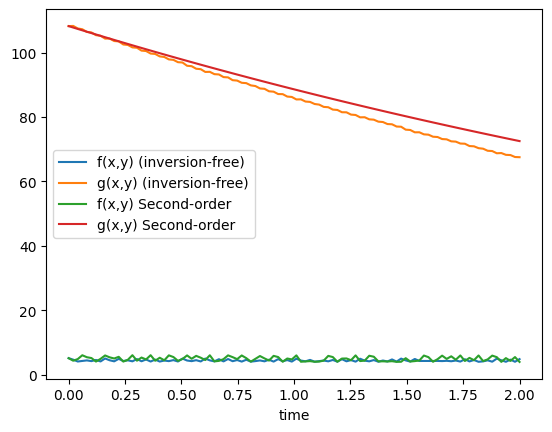

In [6]:
for inversionFree in [True, False]:
    torch.manual_seed(0)
    x = torch.randn((100, 1), requires_grad=True, dtype=torch.float32)
    y = torch.randn((100, 1), requires_grad=True, dtype=torch.float32)
    nu = torch.randn((100, 1), requires_grad=True, dtype=torch.float32)


    # Time points where the solution is computed
    t = torch.linspace(0, 2, 100)

    # Solve the system of ODEs
    initial_conditions = torch.cat((x, y), 0)
    solution = torchdiffeq.odeint(system_unconstrained, initial_conditions, t, method='rk4')

    lossF, lossG, LLerror = [], [], []
    for i in range(len(solution)):
        lossF.append(f(solution[i, :100], solution[i, 100:200])[0].detach().numpy())
        lossG.append(g(solution[i, :100], solution[i, 100:200]).detach().numpy())

    plt.plot(t, lossF, label='f(x,y)' + (' (inversion-free)' if inversionFree else ' Second-order'))
    plt.plot(t, lossG, label='g(x,y)' + (' (inversion-free)' if inversionFree else ' Second-order'))

plt.xlabel('time')

plt.legend()
plt.show()

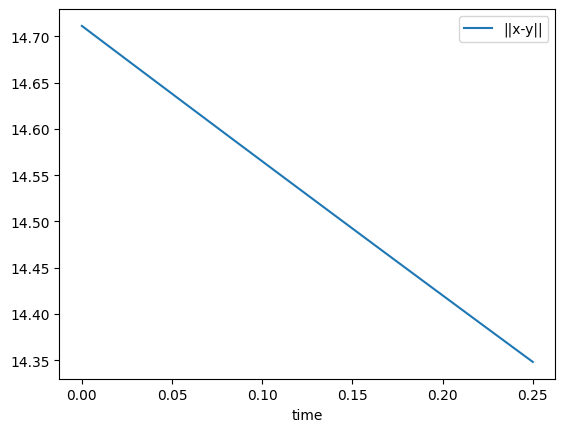

In [13]:
plt.plot(t, torch.linalg.norm(solution[:, :100, 0] - solution[:, 100:200, 0], axis=1, ord=2).detach().numpy(), label='||x-y||')

plt.xlabel('time')
plt.legend()
plt.show()